In [1]:
## only run if using google Colab
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/FCN')

Mounted at /content/drive


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pickle
import matplotlib.pyplot as plt

import utils
import models

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

In [ ]:
### write data to tfrecords file
#utils.write_to_record('data/train.tfrecords', 'data/train.txt', 'data/Images', 'data/Labels', verbose=True)
#utils.write_to_record('data/val.tfrecords', 'data/val.txt', 'data/Images', 'data/Labels', verbose=True)

In [3]:
## read data from tfrecords file
train_dataset = utils.read_from_record('data/train.tfrecords')
val_dataset = utils.read_from_record('data/val.tfrecords')

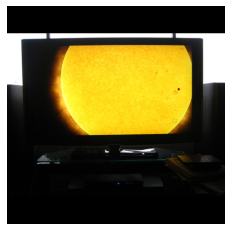

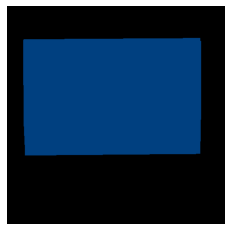

In [ ]:
## check data
for X, y in train_dataset.take(1):
  utils.display_image(X)
  utils.display_image(y)

# Models

In [4]:
## VGG16 base model

base_model = models.vgg16(l2=1e-5, dropout=0.5)

## Load ImageNet weights
## https://keras.io/api/applications/

vgg16 = keras.applications.vgg16.VGG16(weights='imagenet')

weight_list = vgg16.get_weights()
weight_list[26] = weight_list[26].reshape(7, 7, 512, 4096)
weight_list[28] = weight_list[28].reshape(1, 1, 4096, 4096)
weight_list[30] = weight_list[30].reshape(1, 1, 4096, 1000)
base_model.set_weights(weight_list)

553467904/553467096 [==============================] - 6s 0us/step


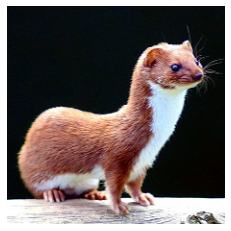

weasel (p=0.791)
mink (p=0.103)
polecat, fitch, foulmart, foumart, Mustela putorius (p=0.103)
black-footed ferret, ferret, Mustela nigripes (p=0.003)
mongoose (p=0.000)


In [5]:
## Test base model
from imagenet_classes import class_names

img = utils.get_image('assets/laska.png', out_dims=(227, 227))
utils.display_image(img)

probs = base_model.predict(np.expand_dims(img, 0))[0, 3, 3] # pick central prediction from 7 x 7 square
pred = np.argsort(probs)[::-1]
for i in range(5):
  c = pred[i]
  print("%s (p=%.3f)" % (class_names[c], probs[c]))

In [32]:
## FCN32

fcn32 = models.fcn32(base_model, l2=1e-5)

## freeze lower layers for fine-tuning
fcn32.get_layer('block1_conv1').trainable=False
fcn32.get_layer('block1_conv2').trainable=False
fcn32.get_layer('block2_conv1').trainable=False
fcn32.get_layer('block2_conv2').trainable=False
fcn32.get_layer('block3_conv1').trainable=False
fcn32.get_layer('block3_conv2').trainable=False
fcn32.get_layer('block3_conv3').trainable=False
fcn32.get_layer('block4_conv1').trainable=False
fcn32.get_layer('block4_conv2').trainable=False
fcn32.get_layer('block4_conv3').trainable=False

## freeze upsample layer
fcn32.get_layer('fcn32').trainable=False

In [7]:
## Load weights, if trained
fcn32.load_weights('weights/fcn32_10e.h5')

In [34]:
## FCN16

fcn16 = models.fcn16(base_model, fcn32, l2=1e-5)

fcn16.get_layer('block4_conv1').trainable=True
fcn16.get_layer('block4_conv2').trainable=True
fcn16.get_layer('block4_conv3').trainable=True

## freeze upsample layer
fcn16.get_layer('score7_upsample').trainable=False
fcn16.get_layer('fcn16').trainable=False

In [15]:
## Load weights, if trained
fcn16.load_weights('weights/fcn16_10e.h5')

In [21]:
## FCN8

fcn8 = models.fcn8(base_model, fcn16, l2=1e-5)

fcn8.get_layer('block1_conv1').trainable=True
fcn8.get_layer('block1_conv2').trainable=True
fcn8.get_layer('block2_conv1').trainable=True
fcn8.get_layer('block2_conv2').trainable=True
fcn8.get_layer('block3_conv1').trainable=True
fcn8.get_layer('block3_conv2').trainable=True
fcn8.get_layer('block3_conv3').trainable=True

## freeze upsample layer
fcn8.get_layer('skip4_upsample').trainable=False
fcn8.get_layer('fcn8').trainable=False



# Training

In [35]:
## Load model

model = fcn16

model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, None,  0                                            
__________________________________________________________________________________________________
preprocessing (Lambda)          (None, None, None, 3 0           input[0][0]                      
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 6 1792        preprocessing[0][0]              
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, None, None, 6 36928       block1_conv1[0][0]               
____________________________________________________________________________________________

In [24]:
## compile

opt = keras.optimizers.Adam(learning_rate=1e-4)

loss = keras.losses.SparseCategoricalCrossentropy(name='cross_entropy')

metrics = [loss, 
           tf.keras.metrics.SparseCategoricalAccuracy(name='pixel_acc'),
           models.SparseMeanIoU(num_classes=21, name='meanIoU')]

model.compile(optimizer=opt, loss=loss, metrics=metrics)

In [25]:
## check running GPU
tf.test.gpu_device_name()

'/device:GPU:0'

In [26]:
## training and validation datasets
train_gen = train_dataset.shuffle(2000).batch(20)
val_gen = val_dataset.shuffle(2857).batch(32)

In [ ]:
history = model.fit(train_gen, epochs=30, validation_data=val_gen)

Epoch 1/30
425/425 [==============================] - 832s 2s/step - loss: 0.1227 - cross_entropy: 0.0706 - pixel_acc: 0.9740 - meanIoU: 0.8565 - val_loss: 0.4277 - val_cross_entropy: 0.3748 - val_pixel_acc: 0.9229 - val_meanIoU: 0.5972
Epoch 2/30
425/425 [==============================] - 830s 2s/step - loss: 0.0969 - cross_entropy: 0.0442 - pixel_acc: 0.9824 - meanIoU: 0.9084 - val_loss: 0.4359 - val_cross_entropy: 0.3852 - val_pixel_acc: 0.9270 - val_meanIoU: 0.6076
Epoch 3/30
425/425 [==============================] - 829s 2s/step - loss: 0.0880 - cross_entropy: 0.0368 - pixel_acc: 0.9851 - meanIoU: 0.9226 - val_loss: 0.4220 - val_cross_entropy: 0.3703 - val_pixel_acc: 0.9258 - val_meanIoU: 0.6106
Epoch 4/30
425/425 [==============================] - 829s 2s/step - loss: 0.1917 - cross_entropy: 0.1398 - pixel_acc: 0.9543 - meanIoU: 0.7318 - val_loss: 0.3837 - val_cross_entropy: 0.3254 - val_pixel_acc: 0.9132 - val_meanIoU: 0.5499
Epoch 5/30
425/425 [==============================] 

In [ ]:
## Save weights and metrics

model.save_weights('weights/fcn8_10e.h5')

with open('logs/fcn8_10', 'wb') as f:
  pickle.dump(history.history, f)

# Testing

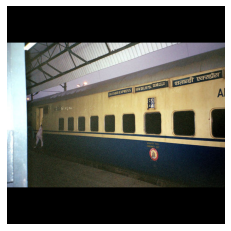

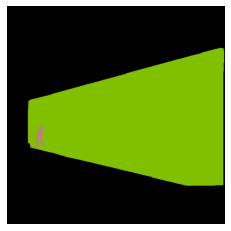

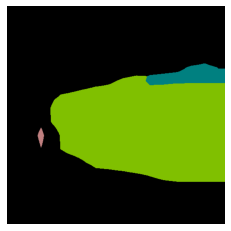

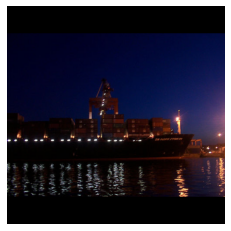

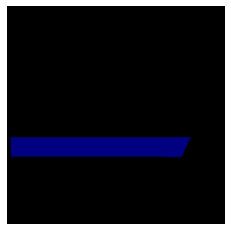

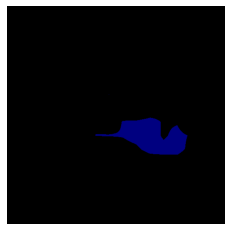

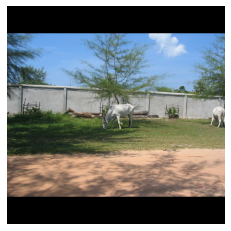

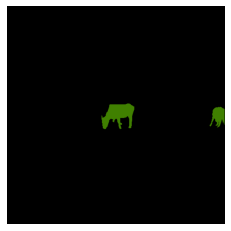

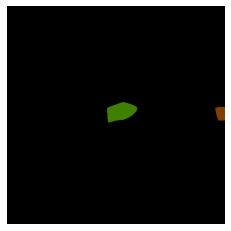

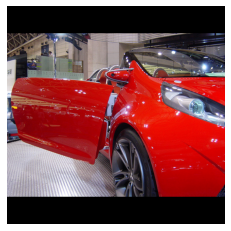

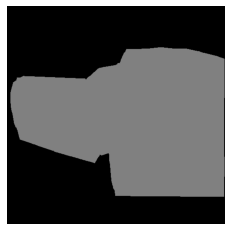

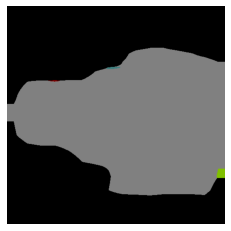

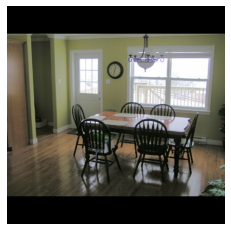

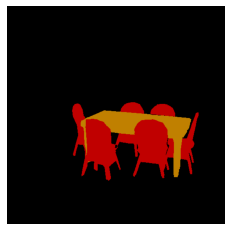

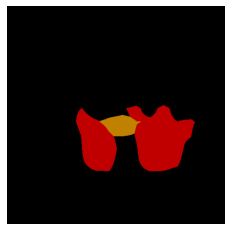

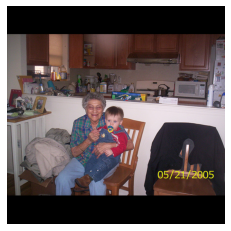

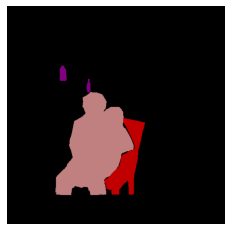

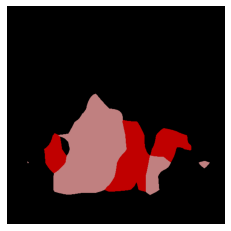

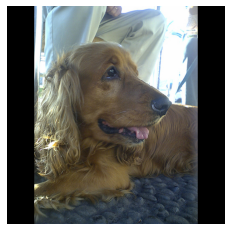

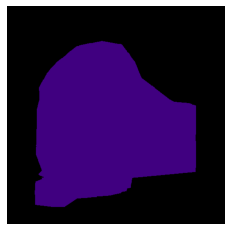

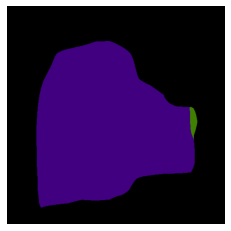

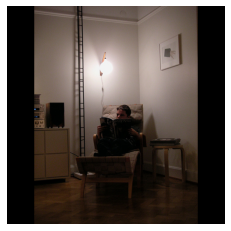

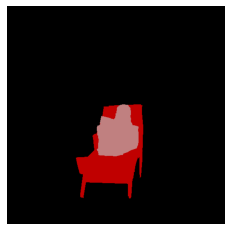

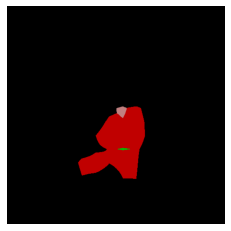

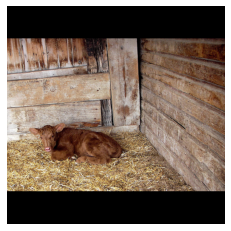

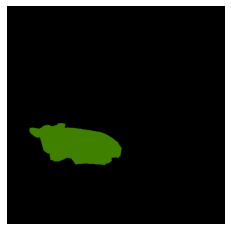

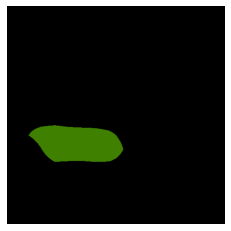

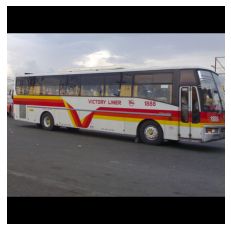

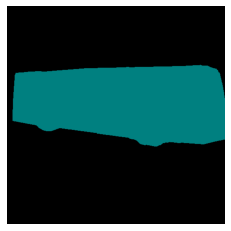

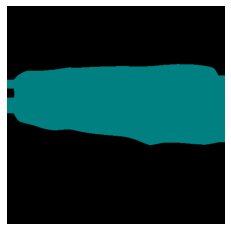

In [12]:
## Test model

sample = val_dataset.take(10)
for X, y in sample:
  
  utils.display_image(X)
  utils.display_image(y)

  y_pred = model.predict(X[np.newaxis,:,:,:])
  utils.display_image(y_pred[0])

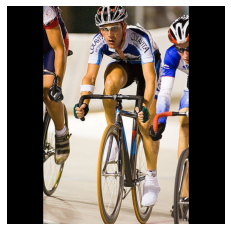

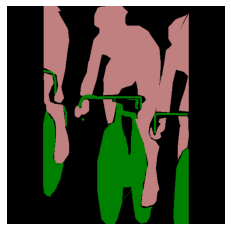

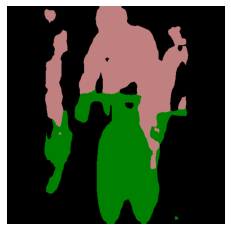

In [ ]:
## example image

image = utils.get_image('assets/biker.jpg')
label = utils.get_label_png('assets/biker_label.png')

y_pred = model.predict(np.expand_dims(image, 0))

utils.display_image(image)
utils.display_image(label)
utils.display_image(y_pred[0])

In [27]:
## Test on validation set

val_test = val_dataset.batch(32)
model.evaluate(val_test)

90/90 [==============================] - 64s 696ms/step - loss: 0.3870 - cross_entropy: 0.3350 - pixel_acc: 0.9320 - meanIoU: 0.6115


[0.41852807998657227,
 0.3669385612010956,
 0.9278454780578613,
 0.6206263303756714]

# Plots

In [29]:
with open('logs/fcn32_10e', 'rb') as f:
  h1 = pickle.load(f)
with open('logs/fcn16_10e', 'rb') as f:
  h2 = pickle.load(f)
with open('logs/fcn8_10e', 'rb') as f:
  h3 = pickle.load(f)

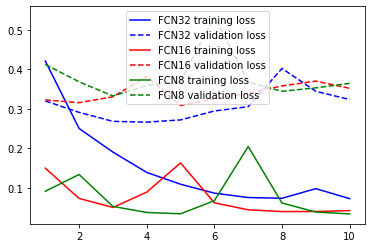

In [30]:
plt.plot(range(1,11), h1['cross_entropy'], '-', color='blue', label='FCN32 training loss')
plt.plot(range(1,11), h1['val_cross_entropy'], '--', color='blue', label='FCN32 validation loss')
plt.plot(range(1,11), h2['cross_entropy'], '-', color='red', label='FCN16 training loss')
plt.plot(range(1,11), h2['val_cross_entropy'], '--', color='red', label='FCN16 validation loss')
plt.plot(range(1,11), h3['cross_entropy'], '-', color='green', label='FCN8 training loss')
plt.plot(range(1,11), h3['val_cross_entropy'], '--', color='green', label='FCN8 validation loss')
plt.legend()
plt.show()


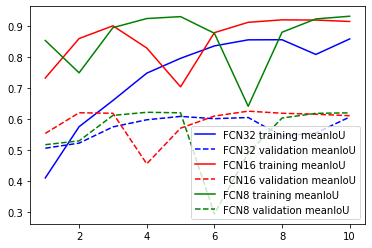

In [31]:
plt.plot(range(1,11), h1['meanIoU'], '-', color='blue', label='FCN32 training meanIoU')
plt.plot(range(1,11), h1['val_meanIoU'], '--', color='blue', label='FCN32 validation meanIoU')
plt.plot(range(1,11), h2['meanIoU'], '-', color='red', label='FCN16 training meanIoU')
plt.plot(range(1,11), h2['val_meanIoU'], '--', color='red', label='FCN16 validation meanIoU')
plt.plot(range(1,11), h3['meanIoU'], '-', color='green', label='FCN8 training meanIoU')
plt.plot(range(1,11), h3['val_meanIoU'], '--', color='green', label='FCN8 validation meanIoU')
plt.legend()
plt.show()